# Predicción de la tasa de desempleo nacional para el año 2018
## Series temporales - LSTM NN
En este caso vamos a tomar el dataset de número de desemplados en los municipios españoles desde enero de 2006 hasta noviembre 2018. Vamos a calcular la tasa de desempleo a partir del dato de habitantes por municipio y finalmente se hará un modelo de predicción para predecir la tasa media de desemepleo nacional para 2018 a partir de los datos de 2006 a 2017. Por último se va a predecir dicha tasa entre los meses de julio y noviembre para comparalo con el método ARIMA. 


In [371]:
import pandas as pd
import numpy as np
import utils
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

Cargamo el dataset de todos los año y concatenamos en vertical

In [5]:
prev_years = range(2006, 2019)
unempl_2006_2018_temp = pd.DataFrame()

for i in prev_years :
    col_read = utils.read_unemployment('./data/Paro_por_municipios_'+str(i)+'.csv')
    unempl_2006_2018_temp = pd.concat([unempl_2006_2018_temp, col_read], axis=0)
    
unempl_2006_2018_temp.head()

año  mes  parados
com_aut   prov    mun                          
Andalucía Almería Abla       2006    1       56
                  Abrucena   2006    1       50
                  Adra       2006    1      775
                  Albánchez  2006    1       14
                  Alboloduy  2006    1       24

Cargamos los habitantes y concatenamos

In [13]:
muns_population = utils.read_population('./data/municipios.csv')
muns_hab = pd.DataFrame(muns_population['habitantes'])
unempl_2006_2018_rates= pd.merge(unempl_2006_2018_temp, muns_hab, how='inner', on=['com_aut','prov','mun'])
unempl_2006_2018_rates.head()

año  mes  parados  habitantes
com_aut   prov    mun                                 
Andalucía Almería Abla  2006    1       56        1504
                  Abla  2006    2       56        1504
                  Abla  2006    3       71        1504
                  Abla  2006    4       68        1504
                  Abla  2006    5       65        1504

Vamos a trabajar con la media nacional de la tasa de desempleo, para calcularla tenemos dos opciones. La primera sería calcular la tasa de desempleo por municipio y mes, y luego hacer una media ponderada con el número de habitantes de cada municipio. La razón de calcular la media ponderada es que ésta sería representativa, ya que, por ejemplo, la tasa de Madrid tiene más peso que la de Villaconejos. La segunda opción consiste en sumar los parados de todos los municipios agrupados por año y mes y dividirlo entre el número total de habitantes.

In [26]:
suma = unempl_2006_2018_rates.groupby(['año','mes']).sum()
suma['tasa'] = suma['parados'].div(suma['habitantes'], axis = 0)
df_rates = suma.drop(['habitantes','parados'], axis = 1)
df_rates.head() 


tasa
año  mes          
2006 1    0.046456
     2    0.046409
     3    0.045965
     4    0.044406
     5    0.042884

#### Separado de train y Test

Separamos el set de train desde enero del 2006 hasta diciembre de 2017 y el test desde enero a noviembre de 2018. 

In [27]:
len(df_rates)

155

In [401]:
train = df_rates[0:144]
test = df_rates[144:155]
test

tasa
año  mes          
2018 1    0.074339
     2    0.074204
     3    0.073183
     4    0.071330
     5    0.069538
     6    0.067614
     7    0.067033
     8    0.068039
     9    0.068477
     10   0.069593
     11   0.069555

#### Escalado
Vamos a usar la normalización como función de escalado, el rango por defecto del MinMaxScaler es de 0 a 1.

In [402]:
sc = MinMaxScaler()
train_set = sc.fit_transform(train)


#### De serie temporal a problema de aprendizaje supervisado
El modelo LSTM asume que el set se divide en componentes de entradas(X) y salidas(Y). Para un problema de series temporales, podemos conseguir esto usando la observación del paso de tiempo anterior (t-1) como la entrada, y la observación actual (t) como salida.



In [403]:
X_train = train_set[0:143]
y_train = train_set[1:144]


El empleo de LSTM implica la predicción de un valor a lo largo del tiempo. La entrada que tenemos actualmente es bidimensional (144 filas x 1 columna), entonces necesitamos añadir otra dimensión a la entrada, el tiempo. Esto es lo que se conoce como reshaping. Keras requiere este formato de entrada y los argumentos tienen que ir en el siguiente orden: batch_size(número de filas), timesteps(número de intervalos de tiempo:mes,dia,etc. que hay entre dos líneas, 1 en nuestro caso) y input_dim (número de columnas).    

Para ellos vamos a usar estos tres argumentos como argumentos de la función reshape de Numpy.





In [404]:
X_train = np.reshape(X_train, (143, 1, 1))

#### Construcción de la red neuronal
Primero hemos de importar 3 clases: la clase secuencial que inicia la RNN, la clase 'densa' que crea la capa de salida de la RNN, y la clase LSTM que hace que la RNN tenga 'Long Memory'.    
Estamos prediciendo una variable contínua por lo que es un problema de regresión, por lo que llamaremos a nuestro modelo (objeto), 'regressor'. Añadimos la capa LSTM, que ella misma toma la capa de entrada como la entrada de si misma. Los argumentos que añadimos a esta capa son, número de neuronas o unidades de memoria, función de activación (sigmoide en nuestro caso, ya que hemos normalizado entre 0 y 1). Existen otros argumentos por defecto y hay otro  adicional, el de la forma de entrada que define el formato de la capa de entrada. Este argumento será 'none' y 1, 'none' especifica que el modelo espera cualquier intervalo de tiempo y uno porque tenemos una columna de entrada. En resumen, el número de neuronas es 4, la función de activación sigmoide y la input_shape, (None,1).    
La siguiente capa que añadimos es la capa de salida. Empleamos una capa 'densa', especificándole el número de neuronas como argumento, que depende de las dimensiones de la salida. Por lo tanto, en nuestro caso será 1.    
Para compilar todas las capas en una única red, usamos la función 'compile' junto con sus argumentos, 'RMSprop' como optimizador ya que en la documentación de Keras dice que es una buena opción para RNN, MSE como criterio de la función de 'loss', y como métrica de test RMSE. Para el resto de argumentos tomamos los valores que vienen por defecto.    
Finalmente entrenamos el modelo 'regressor' con los datos de train. Para ello usamos el método fit. Los argumentos principales incluyen la entrada, salida, batch_size y epochs. Vamos a empezar con eun batch size de 32 (por defecto) y lo iremos disminuyendo si procede y las epochs las cambiamos a 200 para mejor convergencia. Tras varias purebas nos quedamos con un batch_size = 13 y epochs = 400






In [405]:
regressor = Sequential()
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, batch_size = 13, epochs = 400)

Epoch 1/400
143/143 [==============================] - 4s 27ms/step - loss: 0.2365
Epoch 2/400
143/143 [==============================] - 0s 352us/step - loss: 0.2103
Epoch 3/400
143/143 [==============================] - 0s 351us/step - loss: 0.1904
Epoch 4/400
143/143 [==============================] - 0s 333us/step - loss: 0.1731
Epoch 5/400
143/143 [==============================] - 0s 436us/step - loss: 0.1578
Epoch 6/400
143/143 [==============================] - 0s 363us/step - loss: 0.1440
Epoch 7/400
143/143 [==============================] - 0s 322us/step - loss: 0.1316
Epoch 8/400
143/143 [==============================] - 0s 369us/step - loss: 0.1211
Epoch 9/400
143/143 [==============================] - 0s 346us/step - loss: 0.1120
Epoch 10/400
143/143 [==============================] - 0s 342us/step - loss: 0.1038
Epoch 11/400
143/143 [==============================] - 0s 377us/step - loss: 0.0973
Epoch 12/400
143/143 [==============================] - 0s 383us/step - los

143/143 [==============================] - 0s 358us/step - loss: 0.0265
Epoch 98/400
143/143 [==============================] - 0s 340us/step - loss: 0.0257
Epoch 99/400
143/143 [==============================] - 0s 345us/step - loss: 0.0251
Epoch 100/400
143/143 [==============================] - 0s 324us/step - loss: 0.0245
Epoch 101/400
143/143 [==============================] - 0s 340us/step - loss: 0.0237
Epoch 102/400
143/143 [==============================] - 0s 353us/step - loss: 0.0231
Epoch 103/400
143/143 [==============================] - 0s 390us/step - loss: 0.0223
Epoch 104/400
143/143 [==============================] - 0s 332us/step - loss: 0.0216
Epoch 105/400
143/143 [==============================] - 0s 391us/step - loss: 0.0210
Epoch 106/400
143/143 [==============================] - 0s 372us/step - loss: 0.0203
Epoch 107/400
143/143 [==============================] - 0s 335us/step - loss: 0.0197
Epoch 108/400
143/143 [==============================] - 0s 334us/step

143/143 [==============================] - 0s 370us/step - loss: 6.1322e-04
Epoch 191/400
143/143 [==============================] - 0s 387us/step - loss: 6.1832e-04
Epoch 192/400
143/143 [==============================] - 0s 322us/step - loss: 6.2997e-04
Epoch 193/400
143/143 [==============================] - 0s 355us/step - loss: 6.1106e-04
Epoch 194/400
143/143 [==============================] - 0s 346us/step - loss: 6.3147e-04
Epoch 195/400
143/143 [==============================] - 0s 329us/step - loss: 6.2609e-04
Epoch 196/400
143/143 [==============================] - 0s 350us/step - loss: 6.0190e-04
Epoch 197/400
143/143 [==============================] - 0s 356us/step - loss: 6.1366e-04
Epoch 198/400
143/143 [==============================] - 0s 373us/step - loss: 6.3090e-04
Epoch 199/400
143/143 [==============================] - 0s 407us/step - loss: 6.1424e-04
Epoch 200/400
143/143 [==============================] - 0s 350us/step - loss: 6.2682e-04
Epoch 201/400
143/143 [=

143/143 [==============================] - 0s 398us/step - loss: 6.0823e-04
Epoch 282/400
143/143 [==============================] - 0s 347us/step - loss: 5.9501e-04
Epoch 283/400
143/143 [==============================] - 0s 340us/step - loss: 6.1704e-04
Epoch 284/400
143/143 [==============================] - 0s 350us/step - loss: 5.9139e-04
Epoch 285/400
143/143 [==============================] - 0s 339us/step - loss: 6.0643e-04
Epoch 286/400
143/143 [==============================] - 0s 314us/step - loss: 6.0322e-04
Epoch 287/400
143/143 [==============================] - 0s 341us/step - loss: 6.3221e-04
Epoch 288/400
143/143 [==============================] - 0s 341us/step - loss: 5.9495e-04
Epoch 289/400
143/143 [==============================] - 0s 315us/step - loss: 6.1680e-04
Epoch 290/400
143/143 [==============================] - 0s 345us/step - loss: 6.0935e-04
Epoch 291/400
143/143 [==============================] - 0s 337us/step - loss: 5.9154e-04
Epoch 292/400
143/143 [=

143/143 [==============================] - 0s 243us/step - loss: 6.0438e-04
Epoch 373/400
143/143 [==============================] - 0s 295us/step - loss: 5.9982e-04
Epoch 374/400
143/143 [==============================] - 0s 282us/step - loss: 5.9643e-04
Epoch 375/400
143/143 [==============================] - 0s 472us/step - loss: 5.9283e-04
Epoch 376/400
143/143 [==============================] - 0s 382us/step - loss: 6.0374e-04
Epoch 377/400
143/143 [==============================] - 0s 383us/step - loss: 5.9844e-04
Epoch 378/400
143/143 [==============================] - 0s 372us/step - loss: 6.0812e-04
Epoch 379/400
143/143 [==============================] - 0s 343us/step - loss: 5.9886e-04
Epoch 380/400
143/143 [==============================] - 0s 314us/step - loss: 5.8957e-04
Epoch 381/400
143/143 [==============================] - 0s 323us/step - loss: 6.0801e-04
Epoch 382/400
143/143 [==============================] - 0s 373us/step - loss: 5.9611e-04
Epoch 383/400
143/143 [=

Durante el entrenamiento, vemos que la función de 'loss' va disminuyendo hasta resultados razonables, aunque no hablaremos de resultados precisos hasta que no tengamos una 'loss' similar en el set de test.


#### Predicciones y visualización de los resultados
Ahora usamos el modelo para hacer las predicciónes del dataset de test. Tenemos en cuenta que cada predicción es para el mes siguiente, no el actual. La entrada será la tasa_real. Como el modelo esta entrenado con valores escalados (de 0 a 1), tenemos que convertir la entrada con el mismo objeto 'sc' que usamos para escalar el set de train. Además hay que reformatear la entrada a un vector de 3 dimensiones.    
La salida del modelo la guardamos en tasa_predicha. Entonces tendremos la tasa de desempleo nacional para los meses de enero a noviembre de 2018. Finalmente tendremos que usar la inversa del mismo método de transformación 'sc' que empleamos para escalar.



In [406]:
tasa_real = test.values
inputs = tasa_real
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (11, 1, 1))
tasa_predicha = regressor.predict(inputs)
tasa_predicha = sc.inverse_transform(tasa_predicha)
tasa_predicha

array([[0.07454253],
       [0.0744088 ],
       [0.07339717],
       [0.07156141],
       [0.06978555],
       [0.06787933],
       [0.06730334],
       [0.06829978],
       [0.06873416],
       [0.0698399 ],
       [0.06980185]], dtype=float32)

In [407]:
tasa_real

array([[0.07433897],
       [0.07420398],
       [0.07318306],
       [0.07133047],
       [0.06953833],
       [0.06761443],
       [0.06703303],
       [0.06803881],
       [0.06847722],
       [0.06959319],
       [0.06955478]])

Como hemos comentado antes cada predicción es para el mes siguiente, no el actual. Entonces el primer valor de vector tasa_predicha corresponde a febrero y el último a diciembre, mientras que en el vector de entrada tasa real el primer valor corresponde a enero y el último a noviembre. Por lo que para representarlos gráficamente vamos a seleccionar los meses de febrero a noviembre que es el rango que tienen en común ambos arrays.

In [412]:
tasa_predicha_feb_nov = tasa_predicha[0:10]
tasa_real_feb_nov = tasa_real[1:11]

In [413]:
rmse = math.sqrt(mean_squared_error(tasa_real_feb_nov, tasa_predicha_feb_nov))
print('RMSE:',rmse)

RMSE: 0.0012962546455962602


Ahora visualizamos la tasa_predicha y la tasa_real, para ello usamos el módulo pyplot. 


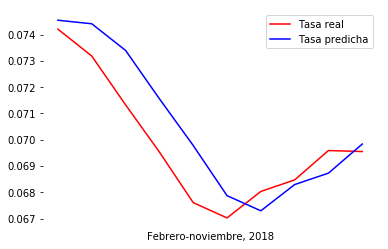

In [414]:
plt.plot(tasa_real_feb_nov, color = 'red', label = 'Tasa real')
plt.plot(tasa_predicha_feb_nov, color = 'blue', label = 'Tasa predicha')
plt.xlabel('Febrero-noviembre, 2018')
plt.xticks([])
plt.box(on=None)
plt.legend()
plt.show()

Tenemos un resultado bastante acertado, incluso a una vista de 11 meses también sigue la tendencia. 

In [415]:
r2_score(tasa_real_feb_nov, tasa_predicha_feb_nov)

0.6679691145804927

Por lo que he leído el r² es mas adecuado para explicar la variabilidad entre dos variables, mientras el RMSE se puede interpretar como la desviación estándar de la varianza sin explicar. Para evaluar una regresión es más adecuado el RMSE (según nos dijo Julio en clase), ya que el r² puede dar lugar a interpretaciones erróneas. Quizas esto es debido a que el r² es una medida relativa del ajuste, mientras que el RMSE es una medida absoluta del ajuste. El error RMSE nos da el error en las mismas unidades que los datos, facilitándonos su interpretación.    
En este caso tenemos un error de 0.0013 según eñ RMSE y un ajuste de 0.67 según r². Con el SVR lineal,tuvimos un r² 0,90 y 0,009 en el RMSE, por lo que en la RNN nos da mejor precisión el RMSE y en la SVR el r². Esta paradoja, sin hacer referencia a los valores ya que las predicciónes han sido diferentes y no comparables, se podría explicar porque como el RMSE penaliza más los errores mayores, el SVR lineal tendría algunos errores de predicción con mayor distancia "de lo normal" entre el valor predicho y el real. Respecto al r² se sabe que a mayor número de features, esta métrica aumenta (esto no sucede con el r² ajustado), el modelo del SVR considera cada año (columnas) como una variable, mientras que la RNN sólo considera una variable, es decir pasamos de 10 a 1.    
Fuente: https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/

Atendiendo a la gráfica este modelo da un poco la impresión de que para predecir el valor a tiempo t, toma un valor muy similar a t-1 real, es decir toma el valor real del mes anterior y lo aumenta ligeramente. Tambíen he resuelto el mismo problema según el método ARIMA, y parece que éste úlitmo saca mejores resultados a corto plazo. Para poder comparar ambos métodos voy a recalcular este ejemplo con la predicción de los meses de julio-novimbre de 2018 como se ha hecho con el ARIMA. Adjunto el HTML del notebook resuelto en R.



In [443]:
train = df_rates[0:149]
test = df_rates[149:155]

sc = MinMaxScaler()
train_set = sc.fit_transform(train)

X_train = train_set[0:148]
y_train = train_set[1:149]

X_train = np.reshape(X_train, (148, 1, 1))

regressor = Sequential()
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, batch_size = 13, epochs = 400, verbose = 0)








RMSE: 0.0009245422947333743


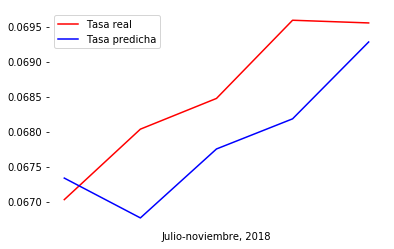

In [420]:
tasa_real = test.values
inputs = tasa_real
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (6, 1, 1))
tasa_predicha = regressor.predict(inputs)
tasa_predicha = sc.inverse_transform(tasa_predicha)

tasa_predicha_feb_nov = tasa_predicha[0:5]
tasa_real_feb_nov = tasa_real[1:6]

rmse = math.sqrt(mean_squared_error(tasa_real_feb_nov, tasa_predicha_feb_nov))
print('RMSE:',rmse)

plt.plot(tasa_real_feb_nov, color = 'red', label = 'Tasa real')
plt.plot(tasa_predicha_feb_nov, color = 'blue', label = 'Tasa predicha')
plt.xlabel('Julio-noviembre, 2018')
plt.xticks([])
plt.box(on=None)
plt.legend()
plt.show()

Parece que se repite la tendencia a tomar como valor a tiempo t, un valor por próximo a t-1 real (en este caso lo disminuye en vez de aumentarlo). Ahora que si podemos comparar ambos métodos, el metodo ARIMA tiene un RMSE menor que la RNN. Ademas,  no se obsserva esta tendencia mencionada (en el mismo período de tiempo, a veces aumenta el valor predicho respecto al valor real del mes anterior y a veces lo dismiuye), es decir el valor predicho no es siempre tan próximo al valor real t-1.